<a href="https://colab.research.google.com/github/HebahAlshamlan/CITC_Task/blob/master/CITC_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_colwidth',400)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset = pd.read_csv('cars.csv')
print(dataset.shape)

dataset.head()

(301, 8)


,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price
0,ritz,2014.0,27000,Petrol,Dealer,Manual,0,3.35
1,sx4,2013.0,43000,Diesel,Dealer,Manual,0,4.75
2,ciaz,2017.0,6900,Petrol,Dealer,Manual,0,7.25
3,wagon r,2011.0,5200,Petrol,Dealer,Manual,0,2.85
4,swift,2014.0,42450,Diesel,Dealer,Manual,0,4.60


In [ ]:
dataset.dtypes


car_name              object
year                 float64
mileage                int64
fuel_type             object
seller_type           object
transmission_type     object
previous_owners        int64
selling_price        float64
dtype: object

In [ ]:
# Find what the duplicate were
dataset.drop_duplicates(subset=None, inplace=True)
dataset.shape

(299, 8)

Exploratory Data Analysis

In [ ]:
print(dataset.selling_price.mean())
print(dataset.selling_price.median()) # There is NO a big difference between mean and median which indicates no outliers.
print(dataset.selling_price.max())
print(dataset.selling_price.min())

4.57063758389262
3.505
35.0
0.1


In [ ]:
dataset.selling_price.sort_values(ascending=False)

86     35.00
64     33.00
63     23.50
82     23.00
51     23.00
       ...  
197     0.16
198     0.15
199     0.12
200     0.10
256      NaN
Name: selling_price, Length: 299, dtype: float64

In [ ]:
print(dataset.selling_price.mean())
print(dataset.selling_price.median())
dataset.selling_price.mode()


4.57063758389262
3.505


0    0.45
1    0.60
dtype: float64

In [ ]:
sns.set(style='darkgrid') # style must be one of white, dark, whitegrid, darkgrid, ticks

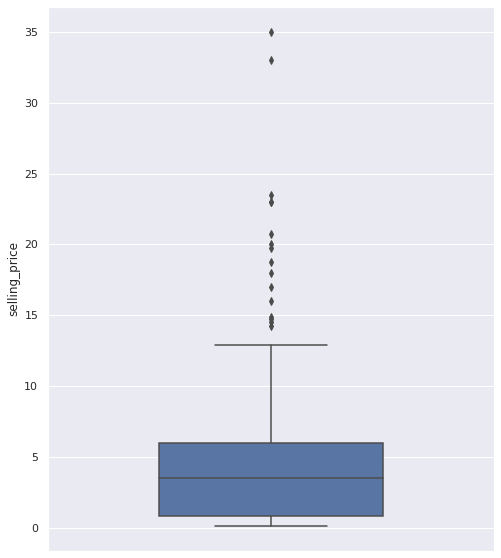

In [ ]:
plt.figure(figsize=(8,10))
sns.boxplot(y='selling_price', data=dataset, width=0.5)

Text(0.5, 1.0, 'Frequency Distribution Plot of Prices')

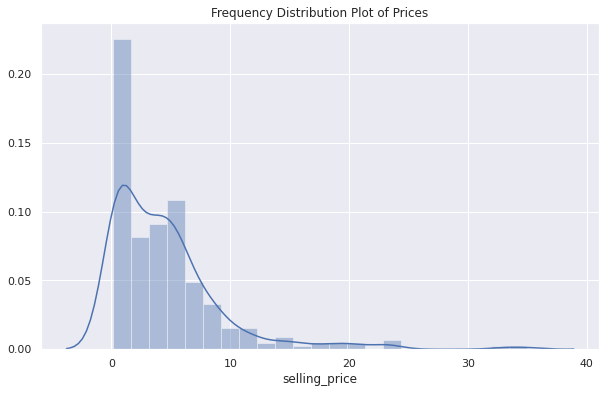

In [ ]:
x = dataset.selling_price
plt.figure(figsize=(10,6))
sns.distplot(x).set_title('Frequency Distribution Plot of Prices')

In [ ]:
dataset = dataset[dataset.selling_price <= 30.00 ]

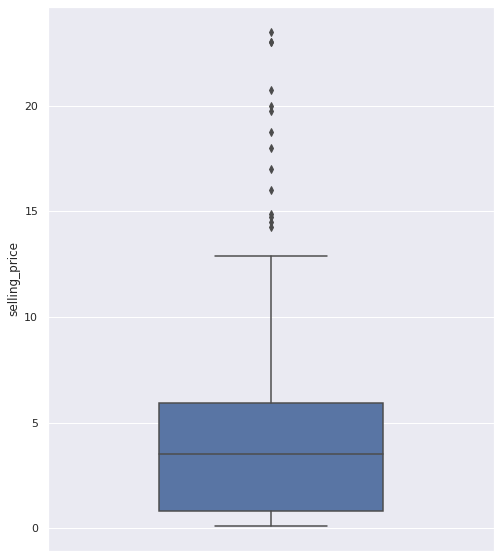

In [ ]:
plt.figure(figsize=(8,10))
sns.boxplot(y='selling_price', data=dataset, width=0.5)

Missing values


In [ ]:
dataset.isna().any()
dataset.isna().sum()

car_name             1
year                 2
mileage              0
fuel_type            0
seller_type          0
transmission_type    0
previous_owners      0
selling_price        0
dtype: int64

In [ ]:
dataset = dataset.dropna(subset=['car_name'])

In [ ]:
# DONT RUN THIS
datayear = dataset.selling_price
# datayear = dataset.mileage
test = datayear.iloc[-1:]       # sliced it here
test2d = test.values.reshape(1,-1)

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(dataset)
ImputedData = imp.transform(dataset.values)
ImputedData

ValueError: ignored

Year

In [ ]:
dataset.year.value_counts() #The age of the car definitely effects the prices. However, instead of the model year of the car, it makes more sense to use is as age. So I will substiture 'year' column from current year.

2015.0    60
2016.0    47
2014.0    38
2013.0    33
2017.0    33
2012.0    23
2011.0    19
2010.0    13
2008.0     7
2009.0     6
2005.0     4
2006.0     4
2003.0     2
2007.0     2
2004.0     1
2018.0     1
Name: year, dtype: int64

In [ ]:
dataset['age'] = 2020 - dataset['year']
dataset.head()

,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price,age
0,ritz,2014.0,27000,Petrol,Dealer,Manual,0,3.35,6.0
1,sx4,2013.0,43000,Diesel,Dealer,Manual,0,4.75,7.0
2,ciaz,2017.0,6900,Petrol,Dealer,Manual,0,7.25,3.0
3,wagon r,2011.0,5200,Petrol,Dealer,Manual,0,2.85,9.0
4,swift,2014.0,42450,Diesel,Dealer,Manual,0,4.60,6.0


Text(0.5, 1.0, 'Frequency Distribution Plot of Age of the Cars')

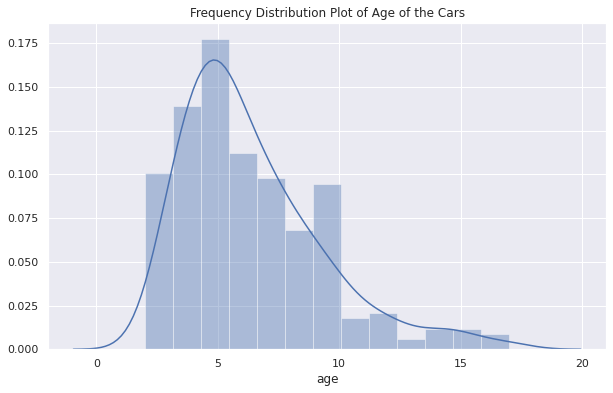

In [ ]:
a = dataset.age
plt.figure(figsize=(10,6))
sns.distplot(a).set_title('Frequency Distribution Plot of Age of the Cars')

mileage

In [ ]:
print(dataset.mileage.mean())
print(dataset.mileage.median())

36767.95593220339
31604.0


Text(0.5, 1.0, 'Frequency Distribution Plot of Km')

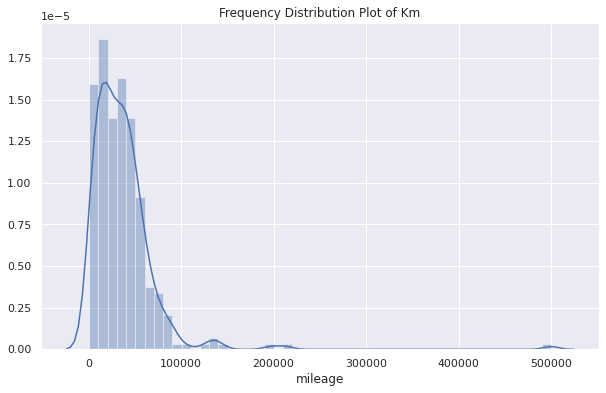

In [ ]:
k = dataset.mileage
plt.figure(figsize=(10,6))
sns.distplot(k).set_title('Frequency Distribution Plot of Km')

Car name

In [ ]:
!conda install -c https://conda.anaconda.org/conda-forge wordcloud --yes
# !conda install --channel conda-forge featuretools --yes


/bin/bash: conda: command not found


In [ ]:
# example of evaluating a model after an imputer transform
from numpy import nan
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# define the imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# define the model
lda = LinearDiscriminantAnalysis()
# define the modeling pipeline
pipeline = Pipeline(steps=[('imputer', imputer),('model', lda)])
# define the cross validation procedure
kfold = KFold(n_splits=3, shuffle=True, random_state=1)
# evaluate the model
result = cross_val_score(pipeline, datayear, dataset, cv=kfold, scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % result.mean())

Accuracy: nan


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected 2D array, got 1D array instead:
array=[ 3.35  4.75  7.25  2.85  6.75  6.5   8.75  7.45  2.85  6.1   7.75  4.9
  4.4   2.5   2.9   3.    4.15  6.    7.45  3.1   2.35  4.95  6.    5.5
  4.65  0.35  3.    2.55  1.95  1.25  2.65  1.05  5.8   7.75 14.9  23.
 16.    2.75  3.6   4.5   4.75  4.1   4.5  18.75  4.75 19.75  9.25  4.35
  3.95  4.5   2.65  4.9   5.5   1.5   5.25 14.5  14.73 12.5   3.49  2.5
  5.9   4.75  3.8  20.75 17.    7.05  1.75  1.7   1.65  1.45  1.35  1.35
  1.25  1.2   1.15  1.15  1.11  1.1   1.1   1.05  1.05  1.05  0.9   0.8
  0.78  0.75  0.75  0.72  0.65  0.65  0.65  0.6   0.6   0.6   0.6   0.6
  0.6   0.6   0.55  0.55  0.52  0.51  0.5   0.5   0.48  0.48  0.48  0.45
  0.45  0.45  0.45  0.42  0.4   0.4   0.4   0.4   0.38  0.35  0.35  0.3
  0.3 

In [ ]:
pd.Series([1, np.nan, 2, None])

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

In [ ]:
x = pd.Series(dataset.car_name, dtype=int)
x

0         ritz
1          sx4
2         ciaz
3      wagon r
4        swift
        ...   
296       city
297       brio
298       city
299       city
300       brio
Name: car_name, Length: 299, dtype: object